# Locate DAS Channels along the Cable from Paradise (Mt Rainier) to Ashford
This script aims to locate the cable from Paradise towards Ashford precisely. It uses a gpx track aquired on 24 Nov 2023 when Manuela and Dominik drove the entire route with a car. 

This script requires to have arrival times picked with the Snuffler tool of the pyrocko python package.

In [26]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
# import h5py
# import datetime
import scipy
# import os
import pandas as pd
# import importlib
# import sys
# sys.path.append('../../2022-25_SPI_GreenFjord/analysis/scripts/GreenFjord_DAS/')
# import DASfuncs
# importlib.reload(DASfuncs)
import obspy

In [31]:
# Create dictionary with some recording information
attrs = {'SpatialSamplingInterval': 9.571,
        'GaugeLength': 9.571}
# Read DAS data as obpsy Stream
st = obspy.read('data/recordings/rainier_10Hz.mseed')

## Read arrival time picks
These are the arrival time picks from Snuffler (pyrocko). 

In [10]:
# Read pick file
df_tap = pd.read_csv('picks/rainier_picks.txt', 
                     delim_whitespace=True, 
                     names=['date','time','1','id','2','3'], 
                     skiprows=1)
df_tap['time'] = pd.to_datetime(df_tap['date']+'T'+df_tap['time'])
df_tap['channel'] = [int(i.split('.')[1]) for i in df_tap['id'].tolist()]
df_tap = df_tap.sort_values('channel', axis=0)
df_tap['OD'] = df_tap['channel']*attrs['SpatialSamplingInterval']  # optical distance
df_tap = df_tap.drop(columns=['date','id','1','2','3'])
df_tap.set_index('channel', inplace=True)
df_tap = df_tap[~df_tap.index.duplicated(keep='first')]  # drop duplicates
df_tap.head()

,time,OD
channel,,
5,2023-11-24 17:59:33.825,47.855
6,2023-11-24 17:59:33.701,57.426
7,2023-11-24 17:59:33.536,66.997
8,2023-11-24 17:59:33.122,76.568
9,2023-11-24 17:59:32.460,86.139


## Read gpx track
That's the track that Dominik and Manuela recorded when driving from Ashford to Paradise.

In [15]:
import pandas as pd
df_track = pd.read_csv('data/tracks/Ashford-Paradise.csv', index_col=0)
df_track['time'] = pd.to_datetime(df_track['time']).dt.tz_convert('UTC')
df_track['time'] = df_track['time'].dt.tz_localize(None)
df_track = df_track[['lat','lon','alt','time']]
df_track

,lat,lon,alt,time
pos,,,,
1,46.759724,-122.039863,528,2023-11-24 17:21:29.399
2,46.759868,-122.039580,529,2023-11-24 17:21:38.400
3,46.759911,-122.039288,530,2023-11-24 17:21:40.400
4,46.759948,-122.038920,530,2023-11-24 17:21:42.400
5,46.759978,-122.038514,530,2023-11-24 17:21:44.400
...,...,...,...,...
932,46.785631,-121.737029,1668,2023-11-24 17:59:33.396
933,46.785553,-121.736595,1667,2023-11-24 17:59:36.396
934,46.785513,-121.736265,1666,2023-11-24 17:59:39.395


In [16]:
# introduce cartesian coordinate system
def latlon2xy(lat,lon,origin):
    '''convert lat,lon to local x,y with origin on Qajuuttap islan'''
    radius = 6371000 # km
    # coordinates of little island
    lat0,lon0 = origin

    dlat = (np.array(lat)-lat0)/180.*np.pi
    dlon = (np.array(lon)-lon0)/180.*np.pi

    y = np.sin(dlat)*radius
    x = np.sin(dlon)*radius*np.cos(np.array(lat)/180.*np.pi)
    return(x,y)

In [24]:
# Convert lat/lon to cartesian coordinates centered at the Visitor Center at Paradise
origin = (46.785856,-121.736935) # Visitor Center at Paradise
xlist, ylist = latlon2xy(df_track['lat'].tolist(), 
                         df_track['lon'].tolist(), 
                         origin)
df_track['x'] = xlist
df_track['y'] = ylist
df_track = df_track[df_track['lon']<=origin[1]]

# reversing data frame and calculating distance along street starting at Paradise
df_track_rev = df_track.iloc[::-1]
df_track_rev.index = df_track.index
df_track_rev['dist'] = np.cumsum(np.sqrt(df_track_rev['x'].diff()**2 + 
                                         df_track_rev['y'].diff()**2))
df_track_rev.loc[1,'dist'] = 0
df_track_rev['dist'] += np.sqrt(df_track_rev.loc[1,'x']**2 + 
                                df_track_rev.loc[1,'y']**2)
df_track = df_track_rev.copy()

## Matching gpx track and arrival time picks
Here comes the magic.

For each pick, we find the closest recorded coordinate (There might be several channels matched with the same coordinate). Now we interpolate locations without a channel pick and resamle to have integer channels pointing to locations.

In [68]:
# For each picked channel, find closest coordinate
df_match = df_track.copy()
df_match.reset_index(inplace=True)
df_match.drop(columns=['pos','time'], inplace=True)
cols = ['lat','lon','alt','x','y','dist']
df_match['channel'] = np.nan
for cha,row in df_tap.iterrows():
    df_copy = df_track.copy()
    match_idx = np.argmin(np.abs(df_track['time'] - row['time']).dt.total_seconds())
    df_match.at[match_idx,'channel'] = int(cha)

# Interpolate locations without a channel pick
max_interp = np.argmax(df_match['channel'])
df_match[:max_interp] = df_match[:max_interp].interpolate()

# Add coordinates of Visitor Center (first channel)
df_match.loc[-1] = [*origin,1667,0,0,0,0]
# # Add last channel in Ashford (this is not very accurate, because we don't know where the cable ends)
# df_match.at[np.max(df_match.index),'channel'] = len(st)
df_match = df_match.sort_values('channel')

# Interpolate to have coordinates for each channel
spline1 = scipy.interpolate.interp1d(df_match['channel'].tolist(), df_match[cols].to_numpy().T, kind='linear', bounds_error=False, fill_value=np.nan)
chas = np.arange(0,len(st))
data_interp = spline1(chas)

# Put interpolated data into DataFrame and calculate uncertainty of location
df_interp = pd.DataFrame(data_interp.T, columns=cols)
df_interp.index = chas
df_interp['OD'] = df_interp.index*attrs['SpatialSamplingInterval']
df_interp.index.name = 'channel'

# Determine an uncertainty from differences in OD and gpx distance
nsta = 3
sta = df_interp['dist'].to_numpy().copy()
# Compute the STA over three channels
sta[nsta:] = sta[nsta:] - sta[:-nsta]
diff = np.abs(sta - nsta*attrs['SpatialSamplingInterval'])/2.
df_interp['unc'] = diff+attrs['GaugeLength']

# Label channels that we have actually picked
df_interp['pick'] = 'False'
df_interp.loc[df_tap.index,'pick'] ='True'

# Resorting
df_interp = df_interp[['OD','lat','lon','alt','x','y','unc','dist','pick']]
df_interp[:10]

,OD,lat,lon,alt,x,y,unc,dist,pick
channel,,,,,,,,,
0,0.000,46.785856,-121.736935,1667.0,0.000000,0.000000,23.927500,0.000000,False
1,9.571,46.785834,-121.736944,1667.1,-0.715702,-2.501886,22.626379,2.602242,False
2,19.142,46.785811,-121.736954,1667.2,-1.431404,-5.003772,21.325258,5.204483,False
3,28.713,46.785789,-121.736963,1667.3,-2.147105,-7.505658,20.024137,7.806725,False
4,38.284,46.785766,-121.736973,1667.4,-2.862807,-10.007543,20.024137,10.408967,False
5,47.855,46.785744,-121.736982,1667.5,-3.578509,-12.509429,20.024137,13.011209,True
6,57.426,46.785721,-121.736991,1667.6,-4.294211,-15.011315,20.024137,15.613450,True
7,66.997,46.785699,-121.737001,1667.7,-5.009913,-17.513201,20.024137,18.215692,True
8,76.568,46.785676,-121.737010,1667.8,-5.725615,-20.015087,20.024137,20.817934,True


## Plot deviation between optical distance along fiber and distance along road

Text(0.5, 0, 'Channel Number')

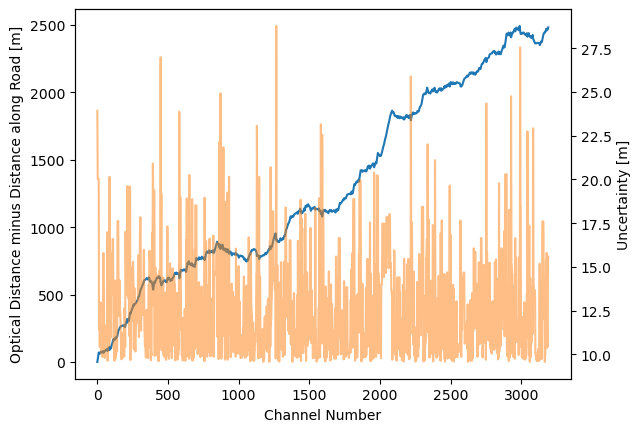

In [33]:
fig, ax = plt.subplots()
ax.plot(df_interp.index, df_interp.index*attrs['SpatialSamplingInterval']-df_interp['dist'])
axt = ax.twinx()
axt.plot(df_interp.index, df_interp['unc'], color='C1', alpha=0.5)
axt.set_ylabel('Uncertainty [m]')
ax.set_ylabel('Optical Distance minus Distance along Road [m]')
ax.set_xlabel('Channel Number')

## Save to .csv file
Here, we save the output to a .csv file. 

In [34]:
# Save to .csv file
df_save = df_interp[['OD','lat','lon','alt','unc','dist','pick']].copy()
formats = {'OD':'{:.1f}', 'lat': '{:.5f}', 'lon': '{:.5f}', 'alt': '{:.0f}', 'unc': '{:.1f}', 'dist': '{:.1f}'}
for col, f in formats.items():
    df_save[col] = df_save[col].map(lambda x: f.format(x))
df_save.index.name = 'Channel'
df_save.to_csv('cable_location/Paradise2NisquallyEntrace_Channels_interp.csv', 
               header=['Optical Distance [m]',
                       'Latitude [°]',
                       'Longitude [°]',
                       'Elevation [m]',
                       'Uncertainty [m]',
                       'Distance along road [m]',
                       'Pick'])

## What's next?
The .csv file can be imported in Google Earth and saved as a .kml file to have a nice view of the cable layout with information about the location of each channel.

## Different approach
For each picked channel, find closest coordinate. Interpolate coordinates for all channels between picked channels. Caveat: Where we don't have picks, we interpolate a straight line.

In [35]:
# For each picked channel, find closest coordinates
df_match = df_tap[['OD']].copy()
cols = ['lat','lon','alt','x','y','dist']
df_match[cols] = np.nan
for i,row in df_tap.iterrows():
    df_copy = df_track.copy()
    df_copy['dt'] = np.abs(df_track['time'] - row['time']).dt.total_seconds()
    df_copy.sort_values('dt', inplace=True)
    df_copy = df_copy[:2] # the two closest samples in time
    df_copy['weight'] = 1-df_copy['dt']/df_copy['dt'].sum()
    # df_copy[df_copy['dt']>15.]['weight'] = np.nan
    interp = (df_copy[cols].mul(df_copy['weight'], axis=0)).sum()/df_copy['weight'].sum()
    df_match.loc[i,cols] = interp
    
# Add coordinates of Visitor Center (first channel)
df_match.loc[0] = [0.,*origin,1667,0,0,0]
df_match.sort_index(inplace=True)

# Interpolate such that we have coordinates for each channel
spline = scipy.interpolate.interp1d(df_match.index.tolist(), df_match[cols].to_numpy().T, kind='linear')
chas = np.arange(0,df_match.index[-1]+1)
data_interp = spline(chas)

# Create DataFrame with interpolated data and determine uncertainties in location
df_interp = pd.DataFrame(data_interp.T, columns=cols)
df_interp['OD'] = df_interp.index*attrs['SpatialSamplingInterval']
df_interp.index.name = 'channel'
# Determine an uncertainty from differences in OD and gpx distance
nsta = 3
sta = df_interp['dist'].to_numpy().copy()
# Compute the STA over three channels
sta[nsta:] = sta[nsta:] - sta[:-nsta]
diff = np.abs(sta - nsta*attrs['SpatialSamplingInterval'])/2.
df_interp['unc'] = diff+attrs['GaugeLength']

# Label channels that we have actually picked
df_interp['pick'] = 'False'
df_interp.loc[df_tap.index,'pick'] ='True'

df_interp[:25]